In [71]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import random
import cv2 as cv

## Training hyperparametrs

In [72]:
epochs = 100
batch_size = 32

## Prepare data

In [73]:
train_dir = "../training_data/"
test_dir = "../testing_data/"

In [74]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True,
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True,
)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode="grayscale",
    shuffle=True,
    class_mode="categorical",
    batch_size=batch_size,  # number of images to process at a time
    seed=42,
)

valid_data = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    shuffle=True,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    seed=42,
)


Found 7760 images belonging to 9 classes.
Found 862 images belonging to 9 classes.


## Define the model

In [75]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))),
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu")),
model.add(Conv2D(64, (3, 3), activation="relu")),

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(9, activation="softmax"))


In [76]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 flatten_12 (Flatten)        (None, 4096)              0         
                                                     

In [77]:
# save model after evry epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/model-{epoch:02d}-{val_accuracy:.2f}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    period=1,
)

callbacks_list = [checkpoint]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    steps_per_epoch=len(train_data),
    epochs=100,
    validation_steps=len(valid_data),
    callbacks=callbacks_list,
)


Epoch 1/100
243/243 [==============================] - 5s 18ms/step - loss: 0.1451 - accuracy: 0.9608 - val_loss: 0.0480 - val_accuracy: 0.9896
Epoch 2/100
243/243 [==============================] - 4s 17ms/step - loss: 0.0332 - accuracy: 0.9914 - val_loss: 0.0366 - val_accuracy: 0.9930
Epoch 3/100
243/243 [==============================] - 4s 17ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.0416 - val_accuracy: 0.9942
Epoch 4/100
243/243 [==============================] - 4s 17ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0496 - val_accuracy: 0.9942
Epoch 5/100
243/243 [==============================] - 4s 17ms/step - loss: 0.0208 - accuracy: 0.9946 - val_loss: 0.0411 - val_accuracy: 0.9954
Epoch 6/100
243/243 [==============================] - 4s 17ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0598 - val_accuracy: 0.9942
Epoch 7/100
243/243 [==============================] - 4s 16ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.0515 - val_accuracy:

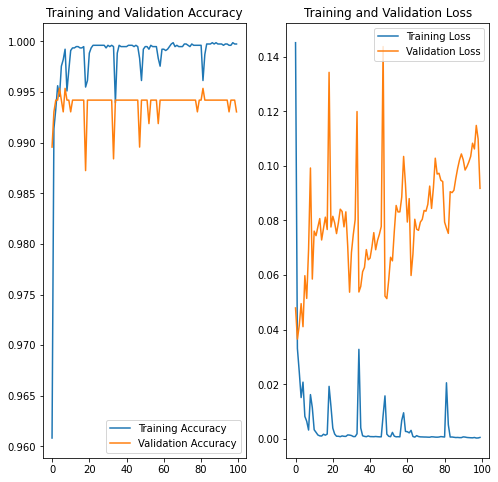

In [80]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


In [81]:
model.save("model.h5")

In [27]:
from scipy import ndimage as ndi


def center_of_mass(img):
    cy, cx, _ = ndi.center_of_mass(img)
    img = img[int(cy) - 20 : int(cy) + 20, int(cx) - 20 : int(cx) + 20]
    return img


def prepare_box_test(img):
    img = np.array(img)
    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0, 5), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    # Left
    while img[:, 0].mean() <= 230:
        img = np.delete(img, 0, 1)

    # Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    mean = img.mean()

    if mean > 250:
        return cv.resize(img, (28, 28))

    cnts3 = img.copy()
    contours2, hierarchy2 = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    all_areas = []

    contours2 = sorted(contours2, key=cv.contourArea, reverse=True)
    contours2 = contours2[1:]

    for cnt in contours2:
        area = cv.contourArea(cnt)
        all_areas.append(area)

    if len(all_areas) == 0:
        return np.zeros((28, 28))

    avg_cnt = sum(all_areas) / len(all_areas)

    for cnt in contours2:
        area = cv.contourArea(cnt)
        if area < avg_cnt:
            cv.drawContours(cnts3, [cnt], -1, (255, 255, 255), -1)

    cnts3 = cnts3[5:]
    cnts3 = cnts3[:-5]
    cnts3 = np.delete(cnts3, range(0, 5), 1)
    cnts3 = np.delete(cnts3, range(-5, 0), 1)
    img = cnts3

    img = center_of_mass(img)
    # img = cv.bitwise_not(img)
    # img = cv.resize(img, (28, 28))

    return img


In [56]:
def cb(img):
    img = np.array(img)
    mean = img.mean()
    non_empty_columns = np.where(img.min(axis=0) < mean)[0]
    non_empty_rows = np.where(img.min(axis=1) < mean)[0]
    box_w = max(non_empty_rows) + 5 - min(non_empty_rows) - 5
    box_h = max(non_empty_columns) - min(non_empty_rows)
    center = (
        min(non_empty_rows) + int(box_w / 2),
        min(non_empty_columns) + int(box_h / 2),
    )
    bb = (center[0] - 20, center[0] + 20, center[1] - 20, center[1] + 20)
    return bb


def prepeare_img(img):
    img = np.array(img)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    # Left
    while img[:, 0].mean() <= 230:
        img = np.delete(img, 0, 1)

    # Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0, 10), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    # Left
    while img[:, 0].mean() <= 230:
        img = np.delete(img, 0, 1)

    # Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    img = img[5:]
    img = img[:-5]
    img = np.delete(img, range(0, 5), 1)
    img = np.delete(img, range(-5, 0), 1)

    # Top
    while img[0].mean() <= 230:
        img = img[1:]

    # Down
    while img[-1].mean() <= 230:
        img = img[:-1]

    # Left
    while img[:, 0].mean() <= 230:
        img = np.delete(img, 0, 1)

    # Right
    while img[:, -1].mean() <= 230:
        img = np.delete(img, -1, 1)

    cnts3 = img.copy()
    contours2, hierarchy2 = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    all_areas = []

    contours2 = sorted(contours2, key=cv.contourArea, reverse=True)
    contours2 = contours2[1:]

    for cnt in contours2:
        area = cv.contourArea(cnt)
        all_areas.append(area)

    avg_cnt = sum(all_areas) / len(all_areas)

    for cnt in contours2:
        area = cv.contourArea(cnt)
        if area < avg_cnt:
            cv.drawContours(cnts3, [cnt], -1, (255, 255, 255), -1)

    cnts3 = cnts3[5:]
    cnts3 = cnts3[:-5]
    cnts3 = np.delete(cnts3, range(0, 5), 1)
    cnts3 = np.delete(cnts3, range(-5, 0), 1)

    return cnts3


def pred_and_plot(img_path, model_path):
    model = tf.keras.models.load_model(model_path)
    fig = plt.figure(figsize=(10, 7))
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1)

    fig.add_subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis(False)

    img2 = img
    img1 = prepeare_img(img)
    img2 = img1
    bb = cb(img1)

    fig.add_subplot(1, 4, 2)
    plt.imshow(img1)
    plt.plot(
        [bb[2], bb[3], bb[3], bb[2], bb[2]], [bb[0], bb[0], bb[1], bb[1], bb[0]], "r-"
    )
    plt.axis(False)

    img1 = img1[bb[0] : bb[1], bb[2] : bb[3]]
    img1 = cv.bitwise_not(img1)
    img1 = cv.resize(img1, (28, 28))

    img2 = prepare_box_test(img2)
    img2 = cv.bitwise_not(img2)
    img2 = cv.resize(img2, (28, 28))

    fig.add_subplot(1, 4, 3)
    plt.imshow(img1)
    plt.axis(False)
    img1 = tf.expand_dims(img1, 0)
    plt.title(np.argmax(model.predict(img1)))

    fig.add_subplot(1, 4, 4)
    plt.imshow(img2)
    plt.axis(False)
    img2 = tf.expand_dims(img2, 0)
    plt.title(np.argmax(model.predict(img2)))

    plt.axis(False)
    plt.colorbar


(43, 36)


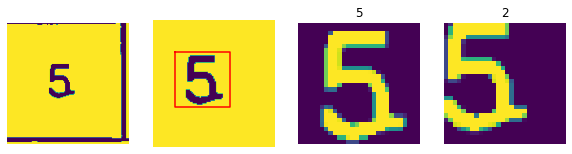

In [74]:
pred_and_plot("box_pre74.png", "models/model-08-0.99.h5")